In [224]:
# Importing LIbraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [225]:
# Loading dataset..
df = pd.read_csv("glassdoor_jobs (1).csv")

In [226]:
df.shape

(956, 15)

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         956 non-null    int64  
 1   Job Title          956 non-null    object 
 2   Salary Estimate    956 non-null    object 
 3   Job Description    956 non-null    object 
 4   Rating             956 non-null    float64
 5   Company Name       956 non-null    object 
 6   Location           956 non-null    object 
 7   Headquarters       956 non-null    object 
 8   Size               956 non-null    object 
 9   Founded            956 non-null    int64  
 10  Type of ownership  956 non-null    object 
 11  Industry           956 non-null    object 
 12  Sector             956 non-null    object 
 13  Revenue            956 non-null    object 
 14  Competitors        956 non-null    object 
dtypes: float64(1), int64(2), object(12)
memory usage: 112.2+ KB


In [228]:
df.duplicated().sum()

0

In [229]:
df.isna().sum()

Unnamed: 0           0
Job Title            0
Salary Estimate      0
Job Description      0
Rating               0
Company Name         0
Location             0
Headquarters         0
Size                 0
Founded              0
Type of ownership    0
Industry             0
Sector               0
Revenue              0
Competitors          0
dtype: int64

In [230]:
df.columns

Index(['Unnamed: 0', 'Job Title', 'Salary Estimate', 'Job Description',
       'Rating', 'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors'],
      dtype='object')

In [231]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,956.0,477.500000,276.117729,0.0,238.75,477.5,716.25,955.0
Rating,956.0,3.601255,1.067619,-1.0,3.30,3.8,4.20,5.0
Founded,956.0,1774.605649,598.942517,-1.0,1937.00,1992.0,2008.00,2019.0


In [232]:
df.nunique()

Unnamed: 0           956
Job Title            328
Salary Estimate      417
Job Description      596
Rating                32
Company Name         448
Location             237
Headquarters         235
Size                   9
Founded              109
Type of ownership     13
Industry              63
Sector                25
Revenue               14
Competitors          149
dtype: int64

In [233]:
# Dropping index column..
df.drop(columns=["Unnamed: 0"], inplace=True)


In [234]:
# df["Salary Estimate"].unique() # To see the all unique text available in salary_estimate column.

In [235]:
# clean salary Text ..
df = df[df["Salary Estimate"] != "-1"]
df["Salary Estimate"] = (
    df["Salary Estimate"]
    .str.replace("Employer Provided Salary:", "", regex=False)
    .str.replace("(Glassdoor est.)", "", regex=False)
    .str.replace("$", "", regex=False)
    .str.replace("K", "", regex=False)
    .str.replace("(Employer est.)","",regex=False)
    .str.replace("Per Hour",'',regex=False)
)
# split the salary range to min and max salary..

df["min_salary"] = df["Salary Estimate"].str.split("-").str[0].astype(int)
df["max_salary"] = df["Salary Estimate"].str.split("-").str[1].astype(int)
# Setting up target variable as avg of max and min_salary..

df["avg_salary"] = (df["min_salary"] + df["max_salary"]) / 2
# view..
df[["Salary Estimate", "min_salary", "max_salary", "avg_salary"]].head()


,Salary Estimate,min_salary,max_salary,avg_salary
0,53-91,53,91,72.0
1,63-112,63,112,87.5
2,80-90,80,90,85.0
3,56-97,56,97,76.5
4,86-143,86,143,114.5


In [236]:
# Job_title Colum..Feature-Engeneering..
# df["job_role"].unique()

def simplify_job(title):
    title = title.lower()
    if "scientist" in title:
        return "Data Scientist"
    elif "engineer" in title:
        return "Data Engineer"        # Simplify the job roles..
    elif "analyst" in title:
        return "Data Analyst"
    elif "manager" in title:
        return "Manager"
    else:
        return "Other"

df["job_role"] = df["Job Title"].apply(simplify_job)
# df.job_role.value_counts()

In [237]:
# Job Description:- Skill Extraction.
df["python"] = df["Job Description"].str.lower().str.contains("python").astype(int)
df["sql"] = df["Job Description"].str.lower().str.contains("sql").astype(int)
df["excel"] = df["Job Description"].str.lower().str.contains("excel").astype(int)
df["ml"] = df["Job Description"].str.lower().str.contains("machine learning").astype(int)


In [238]:
# Company Name:- Clean Rating from compny names..
# df["Company Name"]
df["Company Name"] = df["Company Name"].str.replace("\n.*", "", regex=True)

In [239]:
# Rating:- Ensuring all ratings are greater than 0..
df = df[df["Rating"] > 0]

In [240]:
# Location and Headquarter:-Extracting states
df["job_state"] = df["Location"].str.split(", ").str[-1]
df["hq_state"] = df["Headquarters"].str.split(", ").str[-1]

# Same State Column..
df["same_state"] = (df["job_state"] == df["hq_state"]).astype(int)

In [241]:
# Size:- encoding 
df["Size"].unique()  # 8 unique values...

size_map = {
    "1 to 50 employees": 1,
    "51 to 200 employees": 2,
    "201 to 500 employees": 3,
    "501 to 1000 employees": 4,
    "1001 to 5000 employees": 5,
    "5001 to 10000 employees": 6,
    "10000+ employees": 7,
    "Unknown": 0,                              # only 2 rows contains 0..(unknown)
    "Unknown / Non-Applicable": 0
}

df["company_size"] = df["Size"].map(size_map)


In [242]:
# Founded :- Company Age 
# Founded col is not that useful so i converted it into company age that build the trust..
df["company_age"] = 2025 - df["Founded"]
df["company_age"] = df["company_age"].replace({2026: 0})  # for -1


In [243]:
# Type of ownership, Industry, Sector, Revenue:-
# all of them are categorical text data one hot encoding after grouping .. 
df = pd.get_dummies(
    df,            
    columns=["Type of ownership", "Industry", "Sector", "Revenue"],     # i didnt use label encoding because it dive more importance to the higher number.
    drop_first=True
)

In [244]:
df.shape

(731, 127)

In [245]:
# Compititor:- converted into has_compititor: Binary Feature..
df["has_competitors"] = (df["Competitors"] != "-1").astype(int)


In [246]:
# i created new columns so dropped the older ones..
df.drop(columns=[
    "Job Title", "Salary Estimate", "Job Description",
    "Location", "Headquarters", "Size",
    "Founded", "Competitors"
], inplace=True)


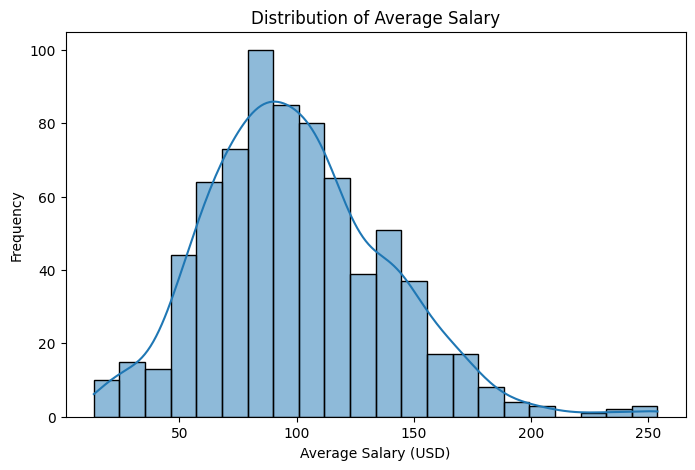

In [247]:
# Create some visualizations to understand the variables:-
# Salary Distribution (Target Variable Understanding)
plt.figure(figsize=(8,5))
sns.histplot(df["avg_salary"], kde=True)
plt.title("Distribution of Average Salary")
plt.xlabel("Average Salary (USD)")
plt.ylabel("Frequency")
plt.show()
# Target feature is Slightly right skewed coz of higher Salary roles..

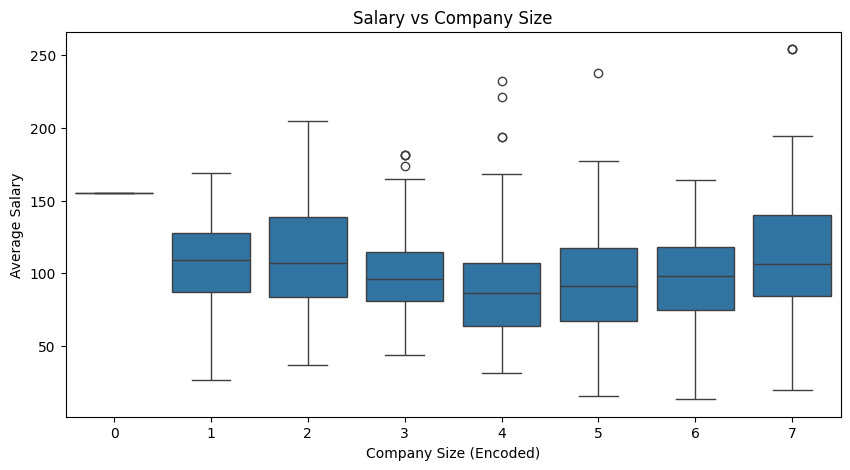

In [248]:
# Salary Distribution:-
plt.figure(figsize=(10,5))
sns.boxplot(x="company_size", y="avg_salary", data=df)
plt.title("Salary vs Company Size")
plt.xlabel("Company Size (Encoded)")
plt.ylabel("Average Salary")
plt.show()


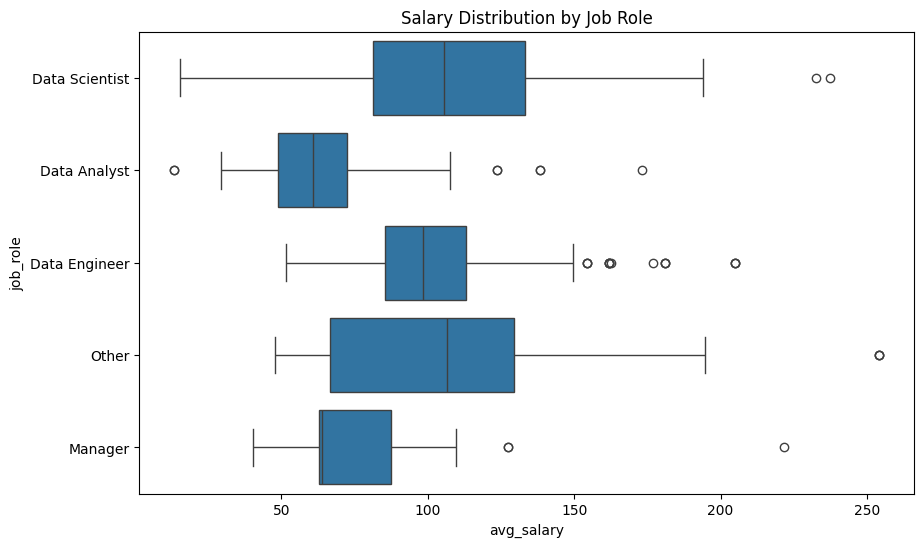

In [249]:
# Salary by Job Title
plt.figure(figsize=(10,6))
sns.boxplot(
    y="job_role",
    x="avg_salary",
    data=df
)
plt.title("Salary Distribution by Job Role")
plt.show()


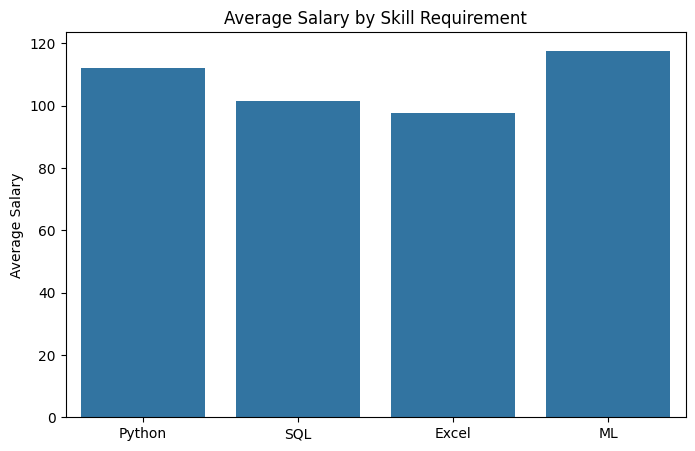

In [250]:
# Skills Impact on Salary..
skills = ["python", "sql", "excel", "ml"]
salary_means = df.groupby(skills)["avg_salary"].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(
    x=["Python", "SQL", "Excel", "ML"],
    y=[
        df[df["python"]==1]["avg_salary"].mean(),
        df[df["sql"]==1]["avg_salary"].mean(),
        df[df["excel"]==1]["avg_salary"].mean(),
        df[df["ml"]==1]["avg_salary"].mean()
    ]
)
plt.title("Average Salary by Skill Requirement")
plt.ylabel("Average Salary")
plt.show()

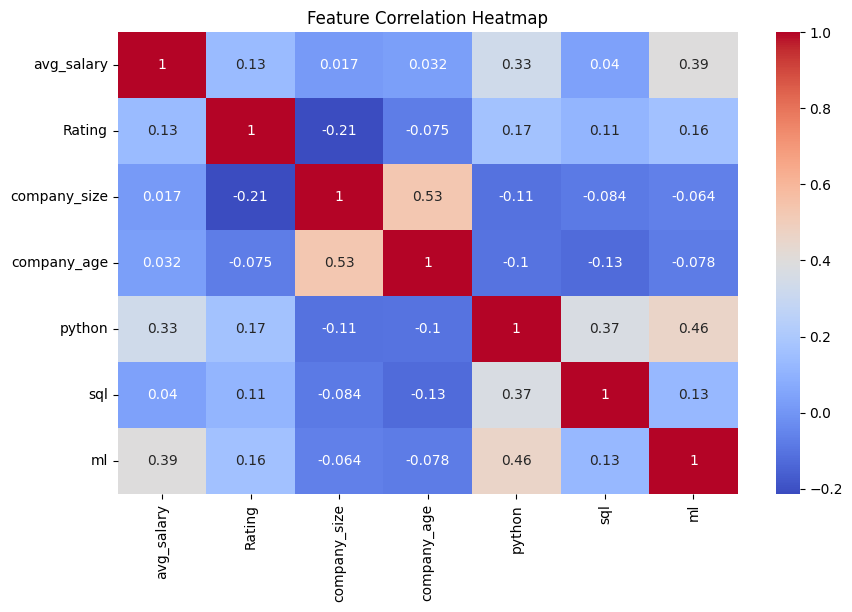

In [251]:
# Correlation Heatmap (Feature–Target Relationship)
plt.figure(figsize=(10,6))
sns.heatmap(
    df[["avg_salary", "Rating", "company_size", "company_age", "python", "sql", "ml"]].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Feature Correlation Heatmap")
plt.show()


In [252]:
# Outlier detection and Outlier Treatment in Target Cloumn:-
# IQR Method
Q1 = df["avg_salary"].quantile(0.25)
Q3 = df["avg_salary"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df[(df['avg_salary']>upper)| (df["avg_salary"]<lower)]
# df["avg_salary"] = df["avg_salary"].clip(lower, upper)

#Transform the target variable..
df["log_salary"] = np.log1p(df["avg_salary"])


In [253]:
# Train-Test split..
y = df["log_salary"]
leakage_cols = ["min_salary","max_salary","avg_salary","log_salary","Company Name","hq_state"] #categorical colsalso :company name and hq_state.

X = df.drop(columns=leakage_cols)

X = pd.get_dummies(X, columns=["job_role"], drop_first=True)

top_states = X["job_state"].value_counts().head(10).index
X["job_state"] = X["job_state"].apply(lambda x: x if x in top_states else "Other")

X = pd.get_dummies(X, columns=["job_state"], drop_first=True)

# Convert boolean columns to integers
bool_cols = X.select_dtypes(include="bool").columns
X[bool_cols] = X[bool_cols].astype(int)

# Train-Test split..
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (584, 127)
X_test shape: (147, 127)
y_train shape: (584,)
y_test shape: (147,)


In [254]:
scale_cols = ["Rating","company_age"]
scaler = StandardScaler()

X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

X_train[scale_cols].describe()

X

,Rating,python,sql,excel,ml,same_state,company_size,company_age,Type of ownership_Company - Private,Type of ownership_Company - Public,...,job_state_IL,job_state_MA,job_state_MD,job_state_NC,job_state_NY,job_state_Other,job_state_PA,job_state_TX,job_state_VA,job_state_WA
0,3.8,1,0,1,1,0,4,52,1,0,...,0,0,0,0,0,1,0,0,0,0
1,3.4,1,0,0,1,1,7,41,0,0,...,0,0,1,0,0,0,0,0,0,0
2,4.8,1,1,1,1,1,4,15,1,0,...,0,0,0,0,0,1,0,0,0,0
3,3.8,1,0,0,1,1,5,60,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2.9,1,1,1,1,1,2,27,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,3.9,0,0,0,0,0,7,195,0,1,...,0,1,0,0,0,0,0,0,0,0
951,4.4,1,1,0,1,0,5,19,0,1,...,0,0,0,0,0,1,0,0,0,0
952,2.6,0,0,1,1,1,4,41,0,0,...,0,0,0,0,0,0,1,0,0,0
953,3.2,0,0,1,1,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [255]:
# Model-1 Linear-Regression (Baselline Model)..
lr = LinearRegression()

lr.fit(X_train, y_train)

# Make Predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Evaluate the Baseline Model..

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

print("Train R2:", r2_score(y_train, y_train_pred))
print("Test R2:", r2_score(y_test, y_test_pred))




Train MAE: 0.20293827289364547
Test MAE: 0.2244787727271287
Train RMSE: 0.2682260036298679
Test RMSE: 0.2976872334621376
Train R2: 0.5982776734149358
Test R2: 0.5534801243047491


In [256]:
# Coefficient Analysis:-
coef_df = (
    pd.DataFrame({
        "Feature": X_train.columns,
        "Coefficient": lr.coef_
    })
    .sort_values(by="Coefficient", ascending=False)
)

coef_df.head(10)

# Shows which features increase salary
# Bottom rows show salary-reducing factors

,Feature,Coefficient
25,Industry_Brokerage Services,0.947232
51,Industry_Investment Banking & Asset Management,0.519959
57,Industry_Motion Picture Production & Distribution,0.400219
114,job_role_Data Scientist,0.364511
116,job_role_Other,0.363508
113,job_role_Data Engineer,0.318246
13,Type of ownership_Other Organization,0.306443
62,Industry_Security Services,0.261865
107,Revenue_$5 to $10 million (USD),0.195926
15,Type of ownership_Subsidiary or Business Segment,0.181350


In [257]:
#  Features are meaningful
#  Salary drivers are captured
#  Linear relationships explain 56% variance
#  Non-linear patterns likely exist (room to improve)

In [258]:
# Model-2:-Decision-Tree-Regressor..
dt = DecisionTreeRegressor(
    random_state=42
)

dt.fit(X_train, y_train)

# predictions..
y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)

# Evaluating Decision Tree..
train_mae_dt = mean_absolute_error(y_train, y_train_pred_dt)
test_mae_dt = mean_absolute_error(y_test, y_test_pred_dt)

train_rmse_dt = np.sqrt(mean_squared_error(y_train, y_train_pred_dt))
test_rmse_dt = np.sqrt(mean_squared_error(y_test, y_test_pred_dt))

train_r2_dt = r2_score(y_train, y_train_pred_dt)
test_r2_dt = r2_score(y_test, y_test_pred_dt)

print("Decision Tree Results")
print("Train MAE:", train_mae_dt)
print("Test MAE:", test_mae_dt)
print("Train RMSE:", train_rmse_dt)
print("Test RMSE:", test_rmse_dt)
print("Train R2:", train_r2_dt)
print("Test R2:", test_r2_dt)


Decision Tree Results
Train MAE: 0.012658908455706814
Test MAE: 0.13032033197558665
Train RMSE: 0.055338318976186636
Test RMSE: 0.24374217565874048
Train R2: 0.9829007864579001
Test R2: 0.7006482910080507


In [259]:
#  PRUNED DECISION TREE

dt_pruned = DecisionTreeRegressor(
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)

dt_pruned.fit(X_train, y_train)

y_train_pred_dt_p = dt_pruned.predict(X_train)
y_test_pred_dt_p = dt_pruned.predict(X_test)

print("\nPruned Decision Tree Results")
print("Train MAE:", mean_absolute_error(y_train, y_train_pred_dt_p))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred_dt_p))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_dt_p)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_dt_p)))
print("Train R2:", r2_score(y_train, y_train_pred_dt_p))
print("Test R2:", r2_score(y_test, y_test_pred_dt_p))



Pruned Decision Tree Results
Train MAE: 0.19838901461577413
Test MAE: 0.2574556795697716
Train RMSE: 0.2721390118587654
Test RMSE: 0.32291644437160383
Train R2: 0.5864711455482894
Test R2: 0.47458713946191666


In [260]:
 # Model:-3--RANDOM FOREST REGRESSOR (DEFAULT MODEL)


from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

print("Random Forest (Default) Results")
print("Train MAE:", mean_absolute_error(y_train, y_train_pred_rf))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred_rf))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_rf)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_rf)))
print("Train R2:", r2_score(y_train, y_train_pred_rf))
print("Test R2:", r2_score(y_test, y_test_pred_rf))


Random Forest (Default) Results
Train MAE: 0.06615508559726681
Test MAE: 0.1391620675254546
Train RMSE: 0.10952185836095031
Test RMSE: 0.19954111524596915
Train R2: 0.933022980120583
Test R2: 0.7993749465160229


In [261]:
#  RANDOM FOREST FEATURE IMPORTANCE

feature_importance = (
    pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": rf.feature_importances_
    })
    .sort_values(by="Importance", ascending=False)
)

feature_importance.head(10)

,Feature,Importance
4,ml,0.174487
7,company_age,0.075987
0,Rating,0.074364
114,job_role_Data Scientist,0.048573
1,python,0.044902
122,job_state_Other,0.035185
44,Industry_Health Care Services & Hospitals,0.033361
87,Sector_Health Care,0.029224
113,job_role_Data Engineer,0.028088
6,company_size,0.027132


In [267]:
# HYPERPARAMETER TUNING (RANDOMIZED SEARCH)
param_grid = {
    "n_estimators": [200, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2"]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X_train, y_train)

rf_random.best_params_

# RESULT:-

# {'n_estimators': 300,
#  'min_samples_split': 2,
#  'min_samples_leaf': 1,
#  'max_features': 'log2',
#  'max_depth': 30}

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 30}

In [263]:
# EVALUATE TUNED RANDOM FOREST

best_rf = rf_random.best_estimator_

y_train_pred_rf_tuned = best_rf.predict(X_train)
y_test_pred_rf_tuned = best_rf.predict(X_test)

print("Random Forest (TUNED) Results")
print("Train MAE:", mean_absolute_error(y_train, y_train_pred_rf_tuned))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred_rf_tuned))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_rf_tuned)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_rf_tuned)))
print("Train R2:", r2_score(y_train, y_train_pred_rf_tuned))
print("Test R2:", r2_score(y_test, y_test_pred_rf_tuned))


Random Forest (TUNED) Results
Train MAE: 0.06417932594384104
Test MAE: 0.13814566519513372
Train RMSE: 0.10528285186195989
Test RMSE: 0.20115199383278634
Train R2: 0.9381072909583927
Test R2: 0.7961226131292173


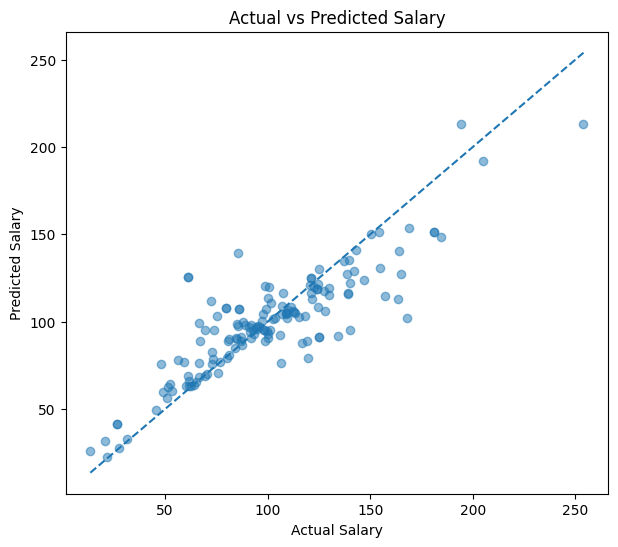

In [264]:
y_test_actual = np.expm1(y_test)
y_test_pred_actual = np.expm1(y_test_pred_rf_tuned)

plt.figure(figsize=(7,6))
plt.scatter(y_test_actual, y_test_pred_actual, alpha=0.5)
plt.plot(
    [y_test_actual.min(), y_test_actual.max()],
    [y_test_actual.min(), y_test_actual.max()],
    linestyle="--"
)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary")
plt.show()


In [266]:
# Important Features..
importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

importances.head(15)


,Feature,Importance
7,company_age,0.069621
4,ml,0.067879
0,Rating,0.064050
1,python,0.053890
6,company_size,0.049292
122,job_state_Other,0.036697
114,job_role_Data Scientist,0.031964
44,Industry_Health Care Services & Hospitals,0.029076
3,excel,0.026852
87,Sector_Health Care,0.024292
